In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
from analysis_functions import *
import uncertainties.unumpy as unp
from uncertainties import ufloat
import json

In [2]:
# run_path = "10.06/run_1_10h41"
# run_path = "10.07/run_1_08h16"
# run_path = "10.08/run_1_08h34"
# run_path = "10.08/run_2_20h05"
# run_path = "10.09/run_1_13h09"
# run_path = "10.10/run_1_08h38"
# run_path = "10.13/run_1_16h51"
run_path = "11.05/run_1_10h51"
# run_path = "11.05/run_2_16h28"
run_path = "11.10/run_1_10h38"
run_path = "11.12/run_1_08h45"

# fresh runs
run_path = "11.19/run_1_12h32"
run_path = "11.20/run_1_09h55"
run_path = "11.21/run_1_08h42"
run_path = "11.22/run_1_09h58"
run_path = "11.23/run_1_20h27"
run_path = "12.01/run_1_10h45"
run_path = "12.10/run_1_14h22" # 300


# carbon steel
# run_path = "10.21/run_1_08h39"
# run_path = "10.21/run_2_12h55"
# run_path = "10.21/run_3_15h32"
# run_path = "10.22/run_1_08h41"
# run_path = "10.28/run_5_16h57"
# run_path = "10.29/run_6_14h14"
# run_path = "10.29/run_8_16h34"
# run_path = "10.30/run_1_11h13"
# run_path = "10.30/run_2_14h20"

# fresh carbon steel runs
run_path = "01.14/run_3_14h02"
# run_path = "01.15/run_1_12h57"
run_path = "01.16/run_1_20h01"
run_path = "01.18/run_1_14h05"
run_path = "01.18/run_2_20h10"
run_path = "01.20/run_1_15h19"
# run_path = "01.21/run_1_09h49"
run_path = "01.21/run_2_14h01"
run_path = "01.23/run_1_09h57"



# Fill in
# material = "316l_steel_fresh" # same format as htm
material = "fresh_steel"
e = 0.00065 # sample thickness in meters measured

In [3]:
results_folder_path = "/Users/colinweaver/Documents/PTTEP/Results/"

data_path = results_folder_path + run_path

# Load the JSON file
with open(data_path + "/run_metadata.json", 'r') as f:
    metadata = json.load(f)

temperature_C_set = metadata["run_info"]["furnace_setpoint"]

R = 8.314 # J/(mol*K)
V = ufloat(7.9e-5, 9.8e-6) # m^3, volume of downstream chamber
# V = 7.9e-5 # m^3, volume of downstream chamber
d_sample = 0.0155 # diameter of fitting on sample in meters
Area = 1/4 * np.pi * (d_sample)**2 # m^2

In [4]:
# Detect which file structure exists and load data accordingly
if os.path.exists(data_path + "/shield_data.csv"):
    # Newest format: combined shield_data.csv
    print("Detected newest format: shield_data.csv")
    t, df = load_downstream_data(data_path + "/shield_data.csv")
    file_format = "newest"
elif os.path.exists(data_path + "/pressure_gauge_data.csv"):
    # Older formats: pressure_gauge_data.csv (with or without thermocouple_data.csv)
    print("Detected older format: pressure_gauge_data.csv")
    t, df = load_downstream_data(data_path + "/pressure_gauge_data.csv")
    file_format = "older"
else:
    raise FileNotFoundError(f"No recognized data file found in {data_path}")

print(df.columns)

# Extract voltage data - try different column name formats
try:
    V_Baratron_downstream = df["Baratron626D_1T_Voltage_V"].to_numpy(dtype=float)
    V_Wasp_downstream = df["WGM701_Voltage_V"].to_numpy(dtype=float)
    V_Baratron_upstream = df["Baratron626D_1KT_Voltage_V"].to_numpy(dtype=float)
    V_Wasp_upstream = df["CVM211_Voltage_V"].to_numpy(dtype=float)
except KeyError:
    V_Baratron_downstream = df["Baratron626D_1T_Voltage (V)"].to_numpy(dtype=float)
    V_Wasp_downstream = df["WGM701_Voltage (V)"].to_numpy(dtype=float)
    V_Baratron_upstream = df["Baratron626D_1KT_Voltage (V)"].to_numpy(dtype=float)
    V_Wasp_upstream = df["CVM211_Voltage (V)"].to_numpy(dtype=float)

t_0 = 0

P_Baratron_downstream = voltage_to_torr_baratron_downstream(V_Baratron_downstream)
P_Wasp_downstream = voltage_to_torr_wasp_downstream(V_Wasp_downstream)
P_Baratron_upstream = voltage_to_torr_baratron_upstream(V_Baratron_upstream)

P_up = average_pressure_after_increase(t, P_Baratron_upstream)  # convert Torr to Pa
# P_up = P_up * 1.05

Detected newest format: shield_data.csv
Index(['RealTimestamp', 'Local_temperature_C',
       'furnace_thermocouple_Voltage_mV', 'WGM701_Voltage_V',
       'CVM211_Voltage_V', 'Baratron626D_1KT_Voltage_V',
       'Baratron626D_1T_Voltage_V'],
      dtype='object')


In [5]:
# Load temperature data based on detected file format

if file_format == "newest":
    # Newest format: thermocouple data is in shield_data.csv
    print("Loading thermocouple data from shield_data.csv")
    T_t = t  # Same time array as pressure data
    try:
        T_data = df["furnace_thermocouple_Voltage_mV"].to_numpy(dtype=float)
    except KeyError:
        T_data = df["furnace_thermocouple_Voltage (mV)"].to_numpy(dtype=float)
    
    T_data = voltage_to_temp_typeK(T_data)
    temperature_C = np.mean(T_data[int(len(T_data)/4):])
    temperature_K = temperature_C + 273.15
    
elif os.path.exists(data_path + "/thermocouple_data.csv"):
    # Older format with separate thermocouple_data.csv
    print("Loading thermocouple data from thermocouple_data.csv")
    
    def load_TC_data(filepath):
        """
        Loads CSV with a datetime RealTimestamp column and returns:
        - time_s : seconds since start (numpy array)
        - df : cleaned DataFrame with Python-safe column names
        """
        # Read CSV
        df = pd.read_csv(filepath)

        # Parse datetimes
        df["RealTimestamp"] = pd.to_datetime(df["RealTimestamp"], errors="coerce")

        # Time since start (0 = first row)
        t0 = df["RealTimestamp"].iloc[0]
        time_s = (df["RealTimestamp"] - t0).dt.total_seconds().to_numpy()

        # Rename columns to be Python-friendly
        df = df.rename(columns=lambda x: x.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_per_"))

        return time_s, df

    T_t, T_df = load_TC_data(data_path + "/thermocouple_data.csv")

    try:
        T_data = T_df["type_K_thermocouple_Voltage_mV"].to_numpy(dtype=float)
    except KeyError:
        T_data = T_df["type K thermocouple_Voltage (mV)"].to_numpy(dtype=float)

    T_data = voltage_to_temp_typeK(T_data)
    temperature_C = np.mean(T_data[int(len(T_data)/4):])
    temperature_K = temperature_C + 273.15
    
else:
    # Oldest format: no thermocouple data file, use setpoint with correction
    print("No thermocouple data file found - using setpoint temperature with correction")
    temperature_K = temperature_C_set + 273.15 - 18
    temperature_C = temperature_K - 273.15
    T_t = t  # Use pressure gauge time for plotting
    T_data = np.full_like(t, temperature_C)  # Constant temperature array for plotting

print(f"Temperature: {temperature_C:.2f} °C ({temperature_K:.2f} K)")

Loading thermocouple data from shield_data.csv
Temperature: 270.16 °C (543.31 K)


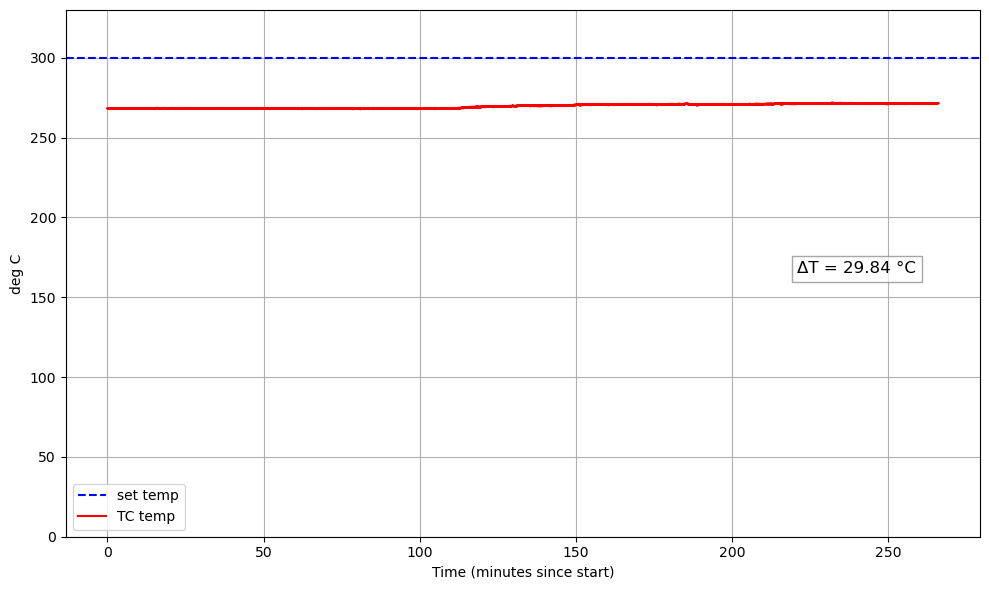

In [6]:
# Plot
plt.figure(figsize=(10, 6))
plt.axhline(temperature_C_set, color='blue', linestyle='--', label='set temp')
plt.plot(T_t/60, T_data, color='red', linestyle='-', label='TC temp')

delta_T = abs(temperature_C - temperature_C_set)

plt.text(
    0.80, 0.5,
    f"ΔT = {delta_T:.2f} °C",
    transform=plt.gca().transAxes,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.xlabel('Time (minutes since start)')
plt.ylabel('deg C')
plt.ylim(0, temperature_C_set * 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

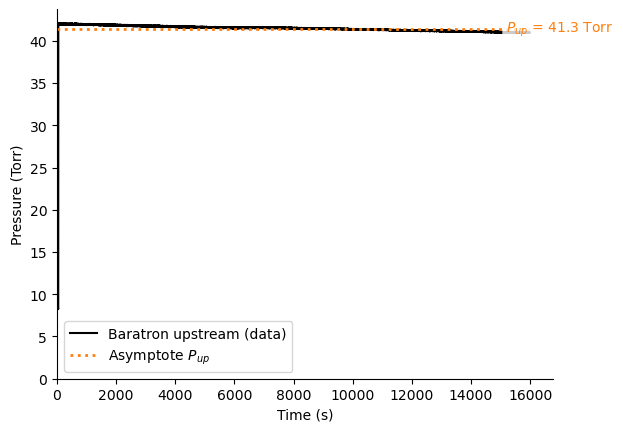

delta_P_up = 0.9713794919662107


In [7]:
plt.figure()
ax = plt.gca()

# Plot upstream Baratron pressure data
ax.plot(t, P_Baratron_upstream, color="black", linewidth=1.5, label="Baratron upstream (data)")

# Draw horizontal asymptote at P_up
ax.hlines(P_up, xmin=float(t[0]), xmax=float(t[-1]),
          linestyles=":", linewidth=2, color="C1", label="Asymptote $P_{up}$")

# Annotate the P_up value on the right-hand side
x_annot = t[-1] - 0.05 * (t[-1] - t[0])  # slightly inset from right edge
ax.text(x_annot, P_up,
        f"$P_{{up}}$ = {P_up:.3g} Torr",
        va="center", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8),
        color="C1")

# Style axes
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

# Save or show
# plt.savefig("baratron_upstream_asymptote.png", dpi=300, bbox_inches="tight")
plt.show()

valid = (P_Baratron_upstream >= P_Baratron_upstream[-1])
delta_P_up = P_Baratron_upstream[valid][50] - P_Baratron_upstream[valid][-1]
print("delta_P_up =", delta_P_up)

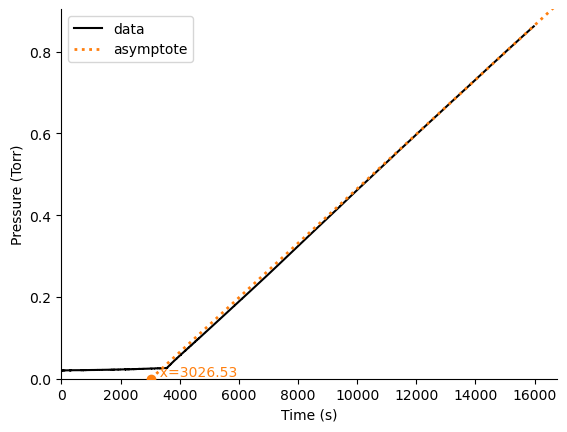

In [8]:
valid = (P_Baratron_downstream >= 0.05) & (P_Baratron_downstream <= 0.95)
t_rise, P_rise = t[valid], P_Baratron_downstream[valid]

plt.figure()
ax = plt.gca()
ax.plot(t, P_Baratron_downstream, color="black", label="data")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Fit asymptote on rising-only
slope, intercept, _ = fit_linear_asymptote(t_rise, P_rise)
if abs(slope) < 1e-12:
    raise ValueError("slope too small")

x_cross = -intercept / slope

# Draw asymptote
x_span = t[-1] - t[0] if t[-1] != t[0] else 1.0
x_end = t[-1] + 0.2 * x_span
x_ext = np.linspace(min(x_cross, x_end), max(x_cross, x_end), 2)
y_ext = slope * x_ext + intercept
ax.plot(x_ext, y_ext, linestyle=":", linewidth=2, color="C1", label="asymptote")

# Mark crossing
if np.isfinite(x_cross):
    ax.scatter([x_cross], [0], color="C1", zorder=5)
    ax.text(x_cross, 0, f"  x={x_cross:.2f}", va="bottom", color="C1")

ax.legend()
plt.show()

In [9]:
# Using timelag to calculate D_eff
tau_l = x_cross - t_0
D_eff = e**2 / (6 * tau_l)
phi_timelag = slope*133.3 / (R*temperature_K/V*(P_up*133.3)**0.5*e*Area) * 6.022*10**23

print(f"Effective diffusion coefficient: D_eff = {D_eff:.2e} m^2/s")
print(f"Permeability from timelag: phi = {phi_timelag:.2e} mol/(m·s·Pa^0.5)")

print(slope *3600)

Effective diffusion coefficient: D_eff = 2.33e-11 m^2/s
Permeability from timelag: phi = (1.03+/-0.13)e+19 mol/(m·s·Pa^0.5)
0.2398480608147689


In [10]:
# Using Flux to calculate permeability

dPdt = slope * 133.3 # convert Torr/s to Pa/s
J = dPdt*V / (R*temperature_K*Area) * 6.022*10**23 # H/(m^2*s)

Perm = J*e / (P_up*133.3)**0.5

print(f"Permeability (continuum calculation): Phi = {Perm:.2e}")

Permeability (continuum calculation): Phi = (4.34+/-0.54)e+12


In [11]:
# Takaishi-Sensui approximation for the Thermal Transpiration Effect correction

V1_ratio = ufloat(0.35, 0.1) # ratio of V1 to total volume
# V1_ratio = 0.35

V1 = V*V1_ratio
V2 = V*(1-V1_ratio)
T1 = temperature_K
T2 = 300 # ambient temperature in Kelvin

A  = 1.24 * 56.3 / 10e-5
B  = 8 * 7.7 / 10e-2
C  = 10.6 * 2.73
d = 0.0155 # diameter of pipe

P2dot = dPdt
P2 = P_Wasp_downstream[-1] * 133.3 # convert Torr to Pa


# --- helper quantities ---
num2 = C*(d*P2)**0.5 + (T2/T1)**0.5 + A*d**2*P2**2 + B*d*P2     # #2
den3 = C*(d*P2)**0.5 + A*d**2*P2**2 + B*d*P2 + 1                # #3
num1 = B*d*P2dot + (C*d*P2dot)/(2*(d*P2)**0.5) + 2*A*d**2*P2*P2dot  # #1

# --- assemble dn/dt ---
n_dot = (V2*P2dot)/(R*T2) \
      + (V1*P2dot)/(R*T1*num2) \
      + (V1*P2*num1)/(R*T1*num2*den3) \
      - (V1*P2*num1)/(R*T1*num2**2)

J_TS = n_dot / Area * 6.022*10**23 # H/(m^2*s)

Perm_TS = J_TS*e / (P_up*133.3)**0.5 # Permeability from Takaishi-Sensui
print(f"Permeability from Takaishi-Sensui: Phi_TS = {Perm_TS:.2e}")

Permeability from Takaishi-Sensui: Phi_TS = (5.11+/-1.01)e+12


In [12]:
# free molecular flow approximation for the Thermal Transpiration Effect correction

dndt = dPdt * (V1/(R*(T2*T1)**0.5) + V2/(R*T2)) # dn/dt from free molecular flow approx

J_FMF = dndt / Area * 6.022*10**23 # H/(m^2*s)

Perm_FMF = J_FMF*e / (P_up*133.3)**0.5 # Permeability from Takaishi-Sensui

print(f"Permeability from Free Molecular Flow: Phi_FMF = {Perm_FMF:.2e}")

Permeability from Free Molecular Flow: Phi_FMF = (7.15+/-0.91)e+12


In [13]:
# Ps = [Perm, Perm_TS, Perm_TS + (Perm_TS - Perm)]

# vals = np.array([x.n for x in Ps])
# errs = np.array([x.s for x in Ps])

# weights = 1 / errs**2
# mean_val = np.sum(weights * vals) / np.sum(weights)
# mean_std = np.sqrt(1 / np.sum(weights))

# Ps_combined = ufloat(mean_val, mean_std)
# print(Ps_combined)

In [14]:
import csv

outdir = "results/figs"
os.makedirs(outdir, exist_ok=True)   # Create folders if not exist
csv_filename = os.path.join(outdir, f"{material}_diffusivities.csv")

write_run_to_csv(csv_filename, run_path, material, temperature_K, P_up, D_eff, Perm_TS)